# Regresión logística aplicada al corpus y tarea Iris

## 1. Lectura del corpus y partición:

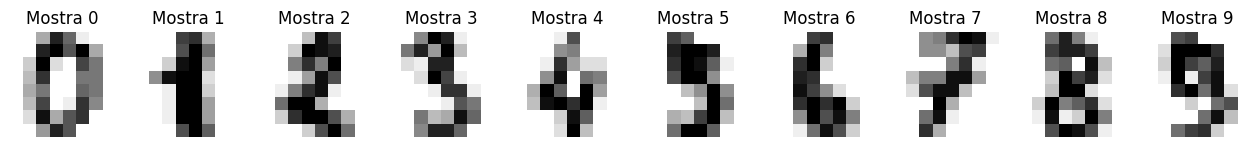

In [11]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Lectura/carga del corpus
digits = load_digits()
X = digits.data.astype(np.float16) # muestras
y = digits.target.astype(np.uint)  # etiquetas de clase

# Partición (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=22)

#mostrar numeros
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 16))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    ax.set_title("Mostra {!s}".format(label))

## 2. Regresión logística

Usamos la implementación de regresión logística (clase [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) de la librería [sklearn](https://scikit-learn.org/).

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Código para filtrar los (molestos) warnings de sklearn sobre convergencia
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

# entrenamiento
model = LogisticRegression(random_state=22).fit(X_train, y_train)

# clasificación (test)
y_test_pred = model.predict(X_test)

# cálculo tasa de error de test
err_test = 1 - accuracy_score(y_test, y_test_pred)
print(f"Error de test: {err_test:.1%}")

Error de test: 2.8%


## 3. Ajuste de hiperparámetros

A continuación se describen algunos hiperparámetros del [método constructor `LogisticRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) que pueden ser ajustados experimentalmente para minimzar la tasa de error en test.

### 3.1 Tolerancia

Como sabemos, el algoritmo de descenso por gradiente actualiza en cada iteración los parámetros del modelo:

$$\boldsymbol{W}_{i+1}=\boldsymbol{W}_i-\eta_i\boldsymbol{\nabla}\mathcal{L}(\boldsymbol{W})\rvert_{\boldsymbol{W}_i}\qquad i=0,1,\ldots$$

El parámetro `tol` establece el umbral de tolerancia mínimo necesario para continuar dicho entrenamiento. Si la magnitud de actualización de parámetros $\Delta = \lVert \,  \eta_i\boldsymbol{\nabla}\mathcal{L}(\boldsymbol{\theta})\rvert_{\boldsymbol{\theta}_i} \, \rVert$ es inferior a `tol` ($\Delta < $ `tol`), el entrenamiento finaliza. Por defecto, `tol = 1e-4`.

In [5]:
for tol in (1e-4, 1e-2, 1, 1e2, 1e4):
    model = LogisticRegression(tol=tol, random_state=22).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con tolerancia {tol}: {err_test:.1%}")

Error de test con tolerancia 0.0001: 2.8%
Error de test con tolerancia 0.01: 3.6%
Error de test con tolerancia 1: 18.9%
Error de test con tolerancia 100.0: 91.1%
Error de test con tolerancia 10000.0: 91.1%


### 3.2 Regularización

La regularización en aprendizaje automático es una técnica utilizada para evitar el sobreajuste (overfitting) de los modelos. El sobreajuste ocurre cuando un modelo se ajusta demasiado a los datos de entrenamiento, pero falla en generalizar a nuevos datos. La regularización introduce una penalización o coste adicional en la función de riesgo empírico o pérdida $\mathcal{L}(\mathbf{\theta})$, desincentivando la complejidad excesiva del modelo (p.e. pesos $w_k$ demasiado grandes) y forzándolo a enfocarse en patrones más generales.

En regresión logística, reescribimos la función de riesgo empírico $\mathcal{L}$ como la $\operatorname{NLL}(\mathbf{W})$, a la que se añade un término o función regularizadora $r(\mathbf{W})$ escalada con un hiperparámetro de ajuste $C$:

$$ \mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) + \frac{r(\mathbf{W})}{C} $$

`LogisticRegression` añade por defecto una regularización del criterio de entrenamiento basada en la norma $\ell_2$:

$$ r(\mathbf{W}) = \lambda \, \lVert \mathbf{W} \rVert_2^2$$

con $\lambda = \frac{1}{2}$ (más detalles [aquí](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)). Entonces:

$$ \mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) +  \frac{\frac{1}{2} \, \lVert \mathbf{W} \rVert_2^2}{C} = \operatorname{NLL}(\mathbf{W}) + \frac{\sum_{i=0}^D \sum_{j=1}^{K} \mathbf{W}_{i,j}^2}{2C}$$

El propósito de esta regularización es evitar un sobre-ajuste del modelo a los datos de entrenamiento, apostando por unos parámetros más sencillos (más próximos a cero):

$$\mathbf{W}^*=\operatorname*{argmin}_{\mathbf{W}}\;\mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) + \frac{\sum_{i=0}^D \sum_{j=0}^{K-1} \mathbf{W}_{i,j}^2}{2C} $$

El hiperparámetro $C$ (positivo, $1.0$ por defecto) permite ajustar a la inversa la magnitud de dicha regularización:
* **Máxima regularización** (sub-ajuste a los datos de train): $\;$ con un valor de `C` próximo a cero.
* **Mínima regularización** (sobre-ajuste a los datos de train): $\;$ con un valor de `C` positivo muy alto.

In [6]:
for C in (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2):
    model = LogisticRegression(C=C, random_state=22).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con C {C:g}: {err_test:.1%}")

Error de test con C 0.001: 4.2%
Error de test con C 0.01: 2.5%
Error de test con C 0.1: 2.2%
Error de test con C 1: 2.8%
Error de test con C 10: 3.3%
Error de test con C 100: 3.3%


### 3.3 Número de iteraciones máximas

El parámetro `max_iter` ($100$ por defecto) permite ajustar el número total de iteraciones del algoritmo de optimización. Ajustaremos este número basándonos en el criterio *Early stopping*: detenemos el entrenamiento lo más pronto posible (en pocas iteraciones) para evitar un sobre-entrenamiento del modelo.

In [7]:
for max_iter in (10, 20, 50, 100):
    model = LogisticRegression(random_state=22, max_iter=max_iter).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con max_iter {max_iter}: {err_test:.1%}")

Error de test con max_iter 10: 3.6%
Error de test con max_iter 20: 4.2%
Error de test con max_iter 50: 3.1%
Error de test con max_iter 100: 2.8%


## 4. Ejercicio

Realiza una exploración combinada de diferentes hiperparámetros, calculando las tasas de error en train y test para cada experimento, mostrándolas en una tabla de resultados (similar a la del [cuaderno del Perceptrón](../P2.S2%20Perceptrón/01_iris.ipynb)). A partir de esta información, determina los valores óptimos de los hiperparámetros. Recuerda que, como regla general, **seleccionaremos el conjunto de valores de hiperparámeros que minimicen la tasa de error en test**.

In [8]:

err_test_minimo = [1,0,0,0]
err_train_minimo = [1,0,0,0]


print("# {:>6s}\t{:>8s}\t{:>4s}\t{:>8s}\t{:>13s}".format("C","max_iter","tol","ERROR TEST","ERROR TRAIN"));
for C in (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2):
  for max_iter in (10, 20, 50, 100):
    for tol in (1e-4, 1e-2, 1, 1e2, 1e4):
      model = LogisticRegression(C = C, tol = tol, max_iter=max_iter ,random_state=22).fit(X_train, y_train)


      err_test = 1 - accuracy_score(y_test, model.predict(X_test))

      if err_test < err_test_minimo[0]:
        err_test_minimo = [err_test,C,max_iter,tol]


      err_train = 1 - accuracy_score(y_train, model.predict(X_train))

      if err_train < err_train_minimo[0]:
        err_train_minimo = [err_train,C,max_iter,tol]

      print("{:8.3f}{:15.2f}{:13.4f}\t{:10.5%}\t{:13.5%} ".format(C,max_iter,tol,err_test, err_train));

print("\nel error de test mínimo ha sido de {:5%} con un nos valores de C, iteraciones máximas y tolerancia de : {:.3f}, {:.2f} y {:4f}".format(err_test_minimo[0],err_test_minimo[1],err_test_minimo[2],err_test_minimo[3]))
print("el error de entrenamiento mínimo ha sido de {:5%} con un nos valores de C, iteraciones máximas y tolerancia de : {:.3f}, {:.2f} y {:.4f}".format(err_train_minimo[0],err_train_minimo[1],err_train_minimo[2],err_train_minimo[3]))

#      C	max_iter	 tol	ERROR TEST	  ERROR TRAIN
   0.001          10.00       0.0001	  4.16667%	     3.61865% 
   0.001          10.00       0.0100	  4.16667%	     3.61865% 
   0.001          10.00       1.0000	 18.88889%	    16.77105% 
   0.001          10.00     100.0000	 91.11111%	    89.83994% 
   0.001          10.00   10000.0000	 91.11111%	    89.83994% 
   0.001          20.00       0.0001	  3.61111%	     2.99235% 
   0.001          20.00       0.0100	  3.61111%	     2.99235% 
   0.001          20.00       1.0000	 18.88889%	    16.77105% 
   0.001          20.00     100.0000	 91.11111%	    89.83994% 
   0.001          20.00   10000.0000	 91.11111%	    89.83994% 
   0.001          50.00       0.0001	  3.33333%	     2.99235% 
   0.001          50.00       0.0100	  3.61111%	     2.92276% 
   0.001          50.00       1.0000	 18.88889%	    16.77105% 
   0.001          50.00     100.0000	 91.11111%	    89.83994% 
   0.001          50.00   10000.0000	 91.11111%	    89.83994% 
   0.00